##**Text generation Experiment**

- 이번 복습과제에는 GPT-2 모델을 사용한 텍스트 생생을 다룹니다. 🙂
- GPT-2는 약 40GB의 인터넷 텍스트 데이터로 훈련된 모델로 다음 단어 예측(next word prediction)을 목적으로 학습이 되었습니다
- Beam Search, Top-k sampling, Top-p sampling 과 같은 다양한 디코딩 기법들을 실험해보겠습니다.

In [ ]:
#reproducability을 위해 해당 코드를 실행해주세요
SEED = 34
#max number of words in output text
MAX_LEN = 70

In [ ]:
# 실험할 문장입니다.
input_sequence = "I don't know about you, but there's only one thing I want to do after a long day of work"

In [ ]:
# transformers을 가져와서 사용해봅시다
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# pretrained large GPT2 tokenizer 와  GPT2 model를 가져와주세요.
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large")
GPT2 = GPT2LMHeadModel.from_pretrained("gpt2-large", pad_token_id=tokenizer.eos_token_id)


In [ ]:
# model parameters을 확인해 봅시다.
# GPT2.summary()
print(GPT2)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3840, nx=1280)
          (c_proj): Conv1D(nf=1280, nx=1280)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=5120, nx=1280)
          (c_proj): Conv1D(nf=1280, nx=5120)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)


In [ ]:
#아래 코드를 실행해주세요-
import tensorflow as tf
tf.random.set_seed(SEED)

### **Greedy-Search**
- Greedy Search 에서는 각 시점마다 가장 확률이 높은 단어를 다음 단어로 선택합니다.
- 즉, 다음 단어는 아래와 같이 업데이트됩니다:

$ wt=argmax wP(w|w1:t−1) $  

> 즉, 각 타임스텝 𝑡마다 조건부 확률이 가장 높은 단어를 선택하는 것!


- 이 단순한 접근방식이 어떤 성능 차이를 보이는지 살펴봅시다.

In [23]:
# context를 encoder해주세요
input_ids = tokenizer.encode(input_sequence, return_tensors='pt')

# 텍스트 생성하기, 이때 output length가 (context length 포함) 50이 될 때까지
greedy_output = GPT2.generate(input_ids, max_length = 50, pad_token_id = tokenizer.eos_token_id)

# output sequences 출력하기
print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens = True))

Output:
----------------------------------------------------------------------------------------------------
I don't know about you, but there's only one thing I want to do after a long day of work: go to the gym.

I'm not talking about the gym that's right next to my house. I'm talking about


💡**위 Greedy Search 식과 코드 결과를 보고 고려되는 주요 문제점을 해당 셀을 풀고 설명해주세요.**


---

Greedy Search로 인해 다음과 같은 문제들이 발생할 수 있습니다.
반복적인 문장을 생성, 문맥 고려가 불가능하기 때문에 부자연스러운 문장 생성을 합니다. Greedy Search는 간단하고 속도가 빠르지만 자연스럽고, 다양한 문장을 생성하지 못한다는 단점이 있습니다.

### **Beam Search + N-Gram Penalty**
- Beam Search는 기본적으로 Greedy Search와 유사하지만, 모델이 각 시점에서 여러 개(num_beams)의 후보 경로를 동시에 추적한다는 점이 다릅니다
 > 즉, 모델이 여러 대안을 비교하면서 텍스트를 생성할 수 있다는 점!


- 또한, n-gram 반복을 방지하기 위한 패널티도 적용할 수 있습니다.예를 들어 `no_repeat_ngram_size = 2`로 설정하면
동일한 2-그램이 두 번 등장하지 않도록 제한됩니다.

- 그리고 `num_return_sequences = 5` 로 설정하면
5개의 beam 결과를 모두 출력하여 비교해볼 수 있습니다.

In [26]:
# Beam Search를 사용하려면,단순히 generate 함수의 몇몇 파라미터만 변경하면 됩니다.
# num_beans를 설정해서 beam search decoding을 실행해주세요
beam_outputs = GPT2.generate(input_ids,
                             max_length = 50,
                             num_beams = 5,
                             num_return_sequences = 5,
                             pad_token_id = tokenizer.eos_token_id)

print('')
print("Output:\n" + 100 * '-')

# output sequences 출력하기
for i, beam_output in enumerate(beam_outputs):
      print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))


Output:
----------------------------------------------------------------------------------------------------
0: I don't know about you, but there's only one thing I want to do after a long day of work, and that's to go home and watch a movie."

"I don't know about you, but there's only one
1: I don't know about you, but there's only one thing I want to do after a long day of work, and that's to go home and watch a movie."

"I don't know about you, but I don't want
2: I don't know about you, but there's only one thing I want to do after a long day of work, and that's to go home and watch a movie."

"I don't know about you, but I want to go
3: I don't know about you, but there's only one thing I want to do after a long day of work, and that's to go home and watch a movie."

"I don't know about you, but I'd like to
4: I don't know about you, but there's only one thing I want to do after a long day of work, and that's to go home and watch a movie."

"I don't know about you, but I don't th

💡**아래 그래프는 Beam Search의 결과와 실제 인간의 말하기 방식 사이의 차이를 보여줍니다. 위 Beam Search 코드 결과와 아래 그래프를  보고 고려되는 주요 문제점을 해당 셀을 풀고 설명해주세요. (기재된 논문에서 힌트를 찾을 수 있습니다.)**


---

인간의 말하기는 확률이 0에서 1 사이에 존재하지만 Beam Search는 매 단계에서 가장 확률이 높은 단어만 선택하기 때문에, 문장의 다양성이 떨어진다.
위의 greedy search처럼 반복적인 문장 생성이 발생할 수 있다.

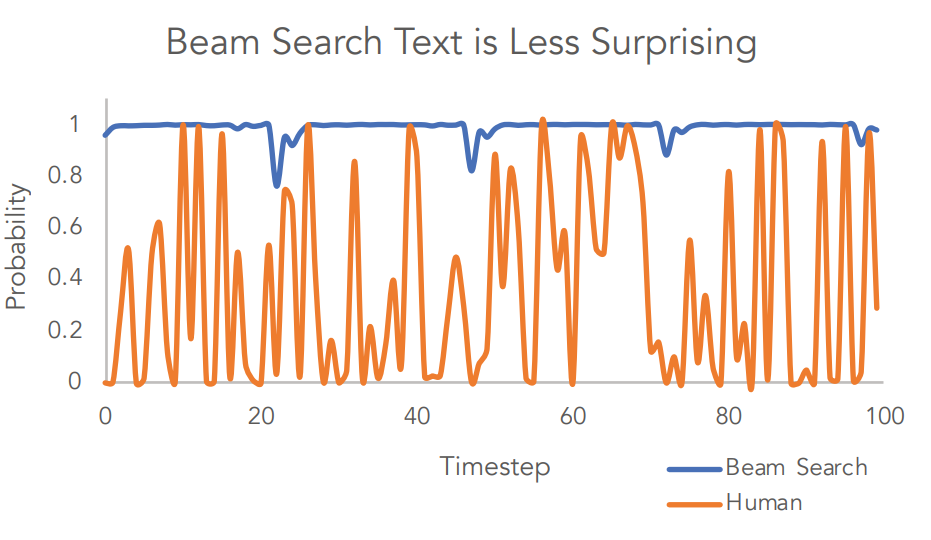

[출처] The Curious Case of Neural Text Degeneration, arXiv:1904.09751 (cs)
https://arxiv.org/abs/1904.09751

### **Basic Sampling**
- 이 방식은 가장 확률이 높은 문장을 찾는 경로를 고집하지 않고, 각 시점에서 조건부 확률 분포에 따라 무작위로 다음 단어를 선택합니다.

$w t​ ∼P(w∣w 1:t−1)$
- 하지만 이렇게 무작위성이 추가되면, 생성된 문장이 일관성이 떨어지고 혼란스러워질 수 있습니다.
- 그래서 무작위성을 제어하기 위해 temperature 파라미터를 도입할 수 있습니다. 이 파라미터는 확률이 높은 단어의 선택 가능성을 높이고, 확률이 낮은 단어는 선택될 가능성을 줄여줍니다.

In [36]:
# 샘플링을 구현하려면 do_sample = True만 설정하면 됩니다.
# temperature을 설정해주세요.
# 이때 top_k = 0으로 설정해주세요.
sample_output = GPT2.generate(input_ids,
                              max_length = 50,
                              do_sample= True,
                              temperature = 0.7,
                              top_k=0,
                              pad_token_id = tokenizer.eos_token_id)
# output sequences 출력하기
print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens = True))

Output:
----------------------------------------------------------------------------------------------------
I don't know about you, but there's only one thing I want to do after a long day of work."

After a brief reply, the girl walked to the door and closed it. "I need to go to the toilet,"


💡**temperature 파라미터가 어떤 매커니즘으로  무작위성을 제어하는지  해당 셀을 풀고 설명해주세요.**


---

모델의 최종 출력 레이어에서 나오는 값을 temperature로 나눈 다음 softmax에 들어간다. 그러므로 temperature가 커질수록 logit 값이 작아지기 때문에 확률이 적은 값을 더 많이 선택하게 되고, temperature가 1보다 작아지면 확률이 높은 값을 더 많이 선택하게 된다.

### **Top-k Sampling**
- Top-K 샘플링에서는 다음 단어 후보 중 확률이 가장 높은 상위 K개 단어만 선택하고,
전체 probability mass을 이 K개의 단어에만 분배합니다.

> 즉, 확률이 높은 단어의 선택 확률을 높이고, 낮은 단어의 확률을 줄이는 방식이 아니라,아예 확률이 낮은 단어들을 완전히 제거하는 방식!

In [46]:
# top_k 값을 설정해서, 조건부 확률 분포에서 고려할 상위 단어 개수(K)를 지정해주세요!
sample_output = GPT2.generate(input_ids,
                              max_length = 50,
                              do_sample= True,
                              temperature = 1,
                              top_k=5,
                              pad_token_id = tokenizer.eos_token_id)
# output sequences 출력하기
print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens = True), '...')

Output:
----------------------------------------------------------------------------------------------------
I don't know about you, but there's only one thing I want to do after a long day of work: go home." He paused and took a breath. "I mean, that's all I want. I'm going to miss the ...


### **Top-P Sampling(Nucleus Sampling)**
- Top-K 샘플링은 이전의 random sampling보다 더 일관된 텍스트를 생성하는 것으로 보입니다. 하지만 이보다 더나은 방법으로 Top-p sampling이 있습니다.
- Top-P 샘플링은 Top-K와 유사하지만,가장 확률이 높은 상위 K개 단어를 고르는 대신,누적 확률이 P 이상이 되는 최소한의 단어 집합을 선택합니다 그리고 전체 probability mass는 이 단어 집합에 재분배됩니다.


In [47]:
# top_p 파라미터를 통해 only from 80% most likely words 만  sample 해주세요.
sample_output = GPT2.generate(input_ids,
                              max_length = 50,
                              do_sample= True,
                              temperature = 1,
                              top_p=0.8,
                              pad_token_id = tokenizer.eos_token_id)

# output sequences 출력하기
print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens = True), '...')

Output:
----------------------------------------------------------------------------------------------------
I don't know about you, but there's only one thing I want to do after a long day of work: I want to watch a show. And in the end, we all get tired. You know, I've always wanted to do ...


### **Top-K + Top-P sampling**
- 둘을 동시에 사용하면, 확률이 매우 낮은 단어(이상한 단어)가 나올 가능성을 줄이면서도, 선택되는 단어 집합의 크기는 유동적으로 유지할 수 있습니다.

In [49]:
# top_k와 top_p에 값을 지정하면 되고, temperature 파라미터도 함께 사용할 수 있습니다.
# 아래 코드를 완성해주세요.
# 이때 max_length= 2*MAX_LEN 으로 설정해주세요
sample_outputs = GPT2.generate(input_ids,
                              max_length = 2*MAX_LEN,
                              do_sample= True,
                              temperature = 1,
                              top_k =5,
                              top_p=0.8,
                              num_return_sequences = 5,
                              pad_token_id = tokenizer.eos_token_id)

# output sequences 출력하기
print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}...".format(i, tokenizer.decode(sample_output, skip_special_tokens = True)))
    print('')

Output:
----------------------------------------------------------------------------------------------------
0: I don't know about you, but there's only one thing I want to do after a long day of work: go for a walk. I don't know if I can find a place to sit in a park, but I can't imagine a place that's as comfortable and relaxing as a quiet park.

The next morning, we took a short stroll to a nearby park, and then headed to the grocery store. We had a few items that we wanted to buy, but we didn't really have much money, so we decided to buy some bread and eggs. We bought some bread, eggs, and a can of tuna, and we were ready to go. We were walking...

1: I don't know about you, but there's only one thing I want to do after a long day of work: go to the gym.

And if you're like me and have a lot of time to kill, I'm here to help. I've been doing CrossFit for a few years now and I've found a lot of great workouts that I'm happy to share with you.

I'm going to show you some great exerc

💡**Top-k와 Top-p의 방식의 차이에 대해 설명해주세요**


---
Top-k 방식은 모델이 예측한 다음 단어 후보들 중에서 확률이 가장 높은 상위 k개의 단어만 남겨놓고, 이 k개 중에서 하나를 무작위로 선택하는 방법이고,
Top-p 방식은 확률의 누적 합이 p가 될 때까지 단어들을 선택하고, 그 후보군 안에서 하나를 무작위로 고르는 방법이다. Top-k는 후보군 문자의 개수가 정해져있고 Top-p는 후보군 문장의 개수가 정해져있지 않다는 차이점이 있다.
